In [1]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
import statsmodels as sm
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
mpl.rcParams['font.family'] = 'Lucida Grande'

## 1.) Configuration

In [80]:
pwd

'/Users/winsonlam/bulbreferral'

In [81]:
# Note: To run this notebook, you will need to change in the config to your currently working directories.

cfg = {
    "directory": {
        "data": "/Users/winsonlam/bulbreferral/Data",
        "output": "/Users/winsonlam/bulbreferral/Output",
    },
    "color_palette":
    {
        "green": "#07B53B",
        "blue": "#15256B",
        "pink": "#E40093",
        "purple": "#4B0471",
        "black": "#020202"
      },
    'datestring': "%Y-%m-%d",
    'plot': {
        'title_fs': 14,
        'figsize': (11, 4)
    }
}

FILE_CUSTOMER = 'Customer_Info.csv'
FILE_REFERRAL = 'Referrals_Info.csv'

## 2.) Data Preparation

In [82]:
def parseDate(df, col, datestring):
    '''
    Parse the date column from string to datetime
    param df: pd.DataFrame
    param col: date column in string format
    param datestring: date format string i.e. "%Y-%m-%d"
    '''
    df[col] = pd.to_datetime(df[col], format = datestring)
    return df

def addDateFeatures(df, col):
    '''
    Add new date feature columns from datetime colums, i,e week, month ...
    param df: pd.DataFrame 
    param col: the column already in datetime format
    '''
    df['dayofweek'] = df[col].dt.dayofweek
    df['week'] = df[col].dt.week
    df['month'] = df[col].dt.month
    df['quarter'] = df[col].dt.quarter 

    return df

def calculateNumBins(data, binwidth):
    '''
    Get the range of bin numbers
    param data: series where min and max can be found
    param binwidth: size of the width of bin (int)
    '''
    bins=range(0, int(max(data)) + binwidth, binwidth)
    return bins

In [83]:
df = pd.read_csv(os.path.join(cfg['directory']['data'], FILE_CUSTOMER))
df = parseDate(df, 'sign_up_date', cfg['datestring'])
df = addDateFeatures(df, 'sign_up_date')

df_ref = pd.read_csv(os.path.join(cfg['directory']['data'], FILE_REFERRAL))
df_ref = parseDate(df_ref, 'referral_date', cfg['datestring'])

df.dtypes

customer_id                 int64
sign_up_date       datetime64[ns]
sign_up_channel            object
dayofweek                   int64
week                        int64
month                       int64
quarter                     int64
dtype: object

In [84]:
# Note: python stores the format (e.g. datetime) in 64-bit integers. We can explicitly format this. For large 
# datasets this can greatly speed up the performance. Since we are dealing with a small file size (<1Mb), we can 
# leave it as is.

## 3.) Data Exploration

In [85]:
start_data, end_data = (df['sign_up_date'].min().date(), df['sign_up_date'].max().date())
print ("The data coverage of the customer dataset is between {} and {}".format(start_data, end_data))

The data coverage of the customer dataset is between 2019-05-07 and 2022-01-03


In [86]:
n_customers = len(set(df['customer_id']))
print ("There are {} unique customer ID in the customer dataset".format(n_customers))

There are 1698 unique customer ID in the customer dataset


In [87]:
n_records = df.shape[0]
print ("There are {} records in the customer dataset".format(n_records))

There are 1699 records in the customer dataset


In [88]:
print ("The Breakdown of the Channel counts are: \n{}".format(df['sign_up_channel'].value_counts()))

The Breakdown of the Channel counts are: 
Price Comparison Website    780
Referral                    565
Bulb Website                354
Name: sign_up_channel, dtype: int64


In [89]:
print ("Number of referrers: {}".format(len(set(df_ref['referrer_customer_id']))))

Number of referrers: 869


In [90]:
pc_referrers = round(100*len(set(df_ref['referrer_customer_id']))/len(set(df['customer_id'])), 2)
print ("Percentage of customers who are referrers: {} %".format(round(pc_referrers, 2)))

Percentage of customers who are referrers: 51.18 %


In [91]:
not_found = len(set(df_ref['referrer_customer_id']) - set(df['customer_id']))
print ('There are {} referrers id not found in customer id in Customer.csv'.format(not_found))

There are 168 referrers id not found in customer id in Customer.csv


### 3.1) Data Cleaning

In [92]:
df['customer_id'].value_counts()

116     2
2047    1
2675    1
616     1
2665    1
       ..
311     1
2360    1
313     1
2362    1
0       1
Name: customer_id, Length: 1698, dtype: int64

In [93]:
print ('Customer with id 116 has 2 records of sign_up_date. Removed duplicate and keep the latest record')

Customer with id 116 has 2 records of sign_up_date. Removed duplicate and keep the latest record


In [94]:
# Remove duplicates of customer id but keep latest record
df = df.sort_values('sign_up_date', ascending = False).\
drop_duplicates(subset=['customer_id'], keep = 'first')

In [95]:
# Merge customer and referrals info into df_merge
df_merge = pd.merge(df_ref, df, left_on='referrer_customer_id', right_on='customer_id', how = 'left')
df_merge['day_diff'] = (df_merge['referral_date'] - df_merge['sign_up_date']).dt.days

assert df_ref.shape[0] == df_merge.shape[0], "There seem to be duplicated customer ID in customer_info"

In [96]:
no_signup_date = df_merge['day_diff'].isnull().sum()
print ('There are {} records found with NaT in day difference column due to missing data of referrer\'s signup date'.format(no_signup_date))

There are 170 records found with NaT in day difference column due to missing data of referrer's signup date


## 4.) Data Analysis

### 4.1.) When do members refer?

In [97]:
# Plot Customer Referral times and channel activities

plt.figure(1, figsize = (20, 5))

# Make side-by-side subplots
plt.subplot(1, 2, 1)
data = df_merge['day_diff']
bins = calculateNumBins(data, 25)
plt.hist(data.dropna(), bins = bins, color=cfg['color_palette']['purple'])
plt.xlabel('Time to Referral (day)')
plt.ylabel('Count')
plt.title('Customer Referrals', fontsize = 16, fontname = 'Oswald')
plt.xlim([0, 500])

plt.subplot(1, 2, 2)
df_ts = df.groupby(['sign_up_date', 'sign_up_channel']).size().unstack().fillna(0)
x = df_ts.index
color = list(cfg['color_palette'].keys())
n = 0
for channel in ['Bulb Website', 'Price Comparison Website', 'Referral']:
    y_channel = df_ts[channel]
    plt.plot(x, y_channel, label = channel, color = cfg['color_palette'][color[n]])
    n+=1
plt.xticks(rotation = 0)
plt.title('Customer Sign-up Date', fontsize = 16)
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.savefig(cfg['directory']['output']+ "/Histogram_TS_CustomeReferral_CountVsDifference.png")

In [98]:
perc_below30days = 100*(df_merge['day_diff'] < 30).sum()/len(df_merge)
print ('{}% of the time, a customer would refer bulb to their friends in the first month of joining.'.format(round(perc_below30days, 2)))

perc_below90days = 100*(df_merge['day_diff'] < 90).sum()/len(df_merge)
print ('{}% of the time, a customer would refer bulb to their friends in the first month of joining.'.format(round(perc_below90days, 2)))

sameday_ref = (df_merge['day_diff'] == 0).sum()
print ('There are {} cases where a new customer is referred by the referrer who joined bulb on the same day.'.format(sameday_ref))

23.9% of the time, a customer would refer bulb to their friends in the first month of joining.
43.3% of the time, a customer would refer bulb to their friends in the first month of joining.
There are 36 cases where a new customer is referred by the referrer who joined bulb on the same day.


In [99]:
# Perhaps a small percentage of customers joined Bulb to leverage discounts/promotions?
# The histogram shows most customers make referrals at the very early stage of joining Bulb. 
# The number of referrals reduces as the customer's membership ages.
# Members acquired from the referrals channels are most active in July.
# In early customer info shows activities mainly take place via Bulb website, later dominated by Referral and price comparison websites

### 4.2) Does the channel at which the members are acquired from significantlly impact how they refer?
Original question: Does the channel members are acquired from significantly impact how they refer? 

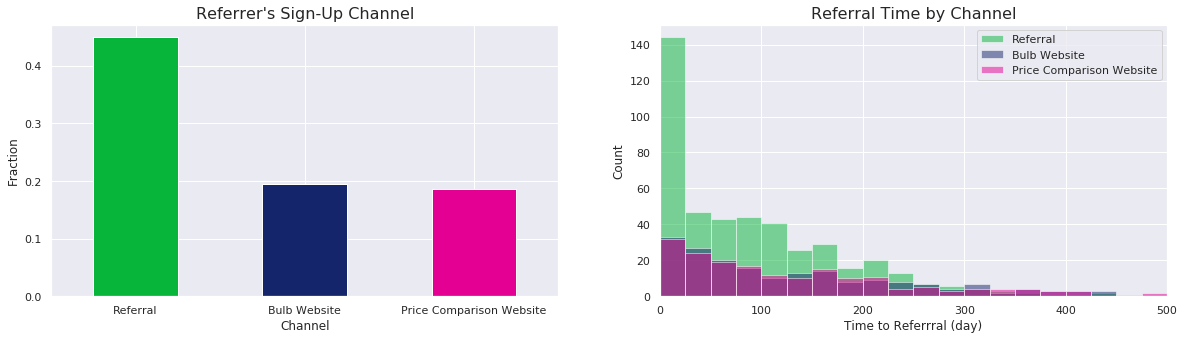

In [100]:
# Plot Referrer's Channel break down and relative proportion over time.

plt.figure(1, figsize = (20, 5))

plt.subplot(1, 2, 1)
((df_merge['sign_up_channel'].value_counts()/len(df_merge))).plot(kind = 'bar', color = cfg['color_palette'].values())
plt.xticks(rotation = 0)
plt.title('Referrer\'s Sign-Up Channel', fontsize = 16)
plt.ylabel('Fraction')
plt.xlabel('Channel')

plt.subplot(1, 2, 2)

color = list(cfg['color_palette'].keys())
n = 0
for channel in ['Referral', 'Bulb Website', 'Price Comparison Website']:
    data = df_merge.loc[df_merge['sign_up_channel'] == channel, 'day_diff']
    bins=calculateNumBins(data, 25)
    plt.hist(data.values, 
             color = cfg['color_palette'][color[n]], bins=bins, label = channel, alpha = 0.5)
    n+=1
plt.legend()
plt.xlabel('Time to Referrral (day)')
plt.xlim([0, 500])
plt.title('Referral Time by Channel', fontsize = 16)
plt.ylabel('Count')

plt.savefig(cfg['directory']['output']+ "/Histogram_referralTimeChannel.png")

In [101]:
# 45% of the referrers joined by referral schemes. 20% by Bulb website, 19% by price comparison sites and the rest
# is unknown due to referrer not found in customer info.
# There is a higher probability of referrers encouraging their friends to join if they are also referred to bulb

### 4.3) We can send an email to members to invite them to refer their friends. When and to which target group should we send it?

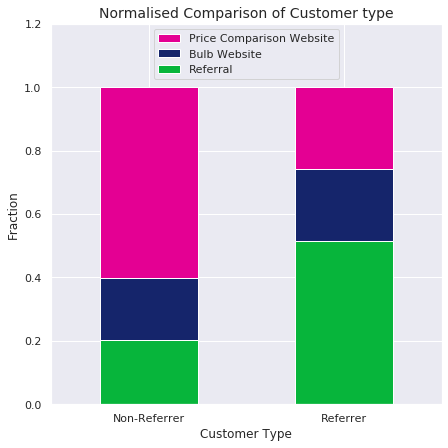

In [102]:
## What is the difference between a referrer and a non_referrer?
referrer_list = set(df_ref['referrer_customer_id'])
df.loc[df['customer_id'].isin(referrer_list), 'customer_type'] = 'Referrer'
df['customer_type'] = df['customer_type'].fillna('Non-Referrer')

colors = list(cfg['color_palette'].values())

referrer_channels = df.groupby(['customer_type', 'sign_up_channel']).size().unstack()/\
    df.groupby('customer_type').size().values.reshape(2, 1)
referrer_channels = referrer_channels[['Referral', 'Bulb Website', 'Price Comparison Website']]
ax = referrer_channels.plot(kind = 'bar', stacked = True, color = colors, figsize = (7, 7))
plt.xticks(rotation = 0)
plt.xlabel('Customer Type')
plt.ylabel('Fraction')
plt.title('Normalised Comparison of Customer type', fontsize = cfg['plot']['title_fs'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper center')
plt.ylim([0, 1.2])
plt.savefig(cfg['directory']['output']+ "/Histogram_referralTimeChannel.png")

In [103]:
# Groupby month and plot and the relative proportions

df_monthxchannel = df.groupby(['month', 'sign_up_channel']).size().unstack()/df.groupby('sign_up_channel').size().values.reshape(1, 3)
# Make column order consistent
month_map = dict(zip([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
                     ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))
df_monthxchannel.index  = [month_map[x] for x in df_monthxchannel.index]

df_monthxchannel = df_monthxchannel[['Referral', 'Bulb Website', 'Price Comparison Website']]
df_monthxchannel.columns.name = 'Channel'
df_monthxchannel.plot(kind = 'bar', color = cfg['color_palette'].values(), figsize = (8, 5))
plt.xlabel('Month')
plt.ylabel('Fraction')
plt.title('Channel Popularity Vs Month', fontsize = cfg['plot']['title_fs'])
plt.xticks(rotation = 0)
plt.savefig(cfg['directory']['output']+ "/Bar_ChannelPopularity.png")

In [104]:
# Groupby day of week and plot and the relative proportions
df_dayofweek = df.groupby(['dayofweek', 'sign_up_channel']).size().unstack()/df.groupby(['sign_up_channel']).size().values.reshape(1, 3)
df_dayofweek = df_dayofweek[['Referral', 'Bulb Website', 'Price Comparison Website']]
df_dayofweek.columns.name = 'Channel'
df_dayofweek.index.name = 'Weekday'
weekday_map = dict(zip([0, 1, 2, 3, 4, 5, 6], ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']))
df_dayofweek.index  = [weekday_map[x] for x in df_dayofweek.index]
df_dayofweek.columns.name = 'Channel'
df_dayofweek.plot(kind = 'bar', color = cfg['color_palette'].values(), figsize = (8, 5))
plt.xlabel('Weekday')
plt.ylabel('Fraction')
plt.title('Channel Popularity Vs Weekdays', fontsize = cfg['plot']['title_fs'])
plt.xticks(rotation = 0)
plt.savefig(cfg['directory']['output']+ "/Bar_ChannelPopularityWeekDays.png")

In [105]:
# Most customers joining bulb via referral scheme takes place in July. Therefore the main group to target should 
# be those who signed up via referral.

# From the table, July attributes to 30% of the Referral scheme signups, therefore, July is the prime time to advertise.
# The most popular day of the week at which the there are new signup customers is sunday 
# This could be due to customers have more free time to sign up, just as sunday is also the most popular day for 
# sign up via comparison websites.
# Interestingly, Monday is the day where sign up is popular via the Bulb website. It could possibly be due to 
# agencies signing up on behalf of a customer.
# Note: (0 is Monday and 6 is Sunday)

# The stacked bar shows the proportion of the sign up channel in each quarter. Generally, Summer is the peak time
# where most customers sign up to Bulb.

### 4.4) Does the data suggest that the referral behaviour of Bulb members changes over time? What trends, if any, do you expect going forward? How would you measure these? 

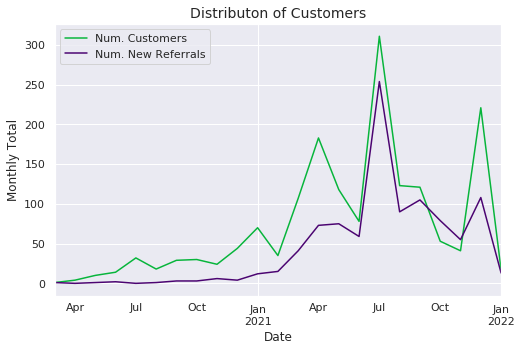

In [106]:
# Plot the distribution of Customers and the newly referred members over time
plt.figure(1, figsize = (8, 5))
n_newCustomers = df_ref.groupby(['referral_date']).size().resample('M').sum().fillna(0)
n_referrers = df.groupby('sign_up_date').size().resample('M').sum().fillna(0)

n_referrers.plot(label = 'Num. Customers', color = cfg['color_palette']['green'])
n_newCustomers.plot(label = 'Num. New Referrals', color = cfg['color_palette']['purple'])

plt.xlim(['2020-03', '2022-01'])
plt.legend()
plt.xlabel('Date')
plt.ylabel('Monthly Total')
plt.title('Distributon of Customers', fontsize = cfg['plot']['title_fs'])
plt.savefig(cfg['directory']['output']+ "/Distribution_of_Customers.png")

In [107]:
# Plot the Probabilty distribution based on the difference between monthly customers and new referrals
plt.figure(1, figsize = (8, 5))
prob_dis = (n_newCustomers/n_referrers).dropna()

# Normalised to between 0 and 1
norm_prob_dis = (prob_dis - prob_dis.min())/(prob_dis.max() - prob_dis.min())
plt.scatter(x = norm_prob_dis.index, y= norm_prob_dis.values, color = cfg['color_palette']['blue'])

prob_rolling = prob_dis.rolling(3, center=False).mean()
plt.plot(prob_rolling.index, prob_rolling.values, color = cfg['color_palette']['pink'], label = 'Rolling Average')
plt.title('Probability Distribution', fontsize = cfg['plot']['title_fs'])
plt.ylabel('Probability')
plt.xlabel('Date')
plt.legend()
plt.savefig(cfg['directory']['output']+ "/Normalised_Probability_Distribution.png")

### 4.5) Are there any other actions you would recommend based on your analysis

In [108]:
plt.figure(1, figsize = (20, 5))
plt.subplot(1, 2, 1)

df_refts = df_ref.groupby('referral_date').size().resample('W').sum()
x = df_refts.index
y = df_refts.values
plt.plot(x, y, label = 'Num. New Referrals', color = cfg['color_palette']['green'])

df_refferalsignup = df.loc[df['sign_up_channel'] == 'Referral'].groupby(['sign_up_date']).size().resample('W').sum()
x1 = df_refferalsignup.index
y1 = df_refferalsignup.values
plt.plot(x1, y1, label = 'Referral Channel', color = cfg['color_palette']['pink'])

plt.xlim(['2020-11', '2022-01'])
plt.ylim(bottom = 0)
plt.ylabel('Weekly Total')
plt.xlabel('Date')
plt.title('Referral Channel & New Referrals', fontsize = 16)
plt.legend()

plt.subplot(1, 2, 2)

start = '2021-02'
end = '2022-01'
y = df_refts.loc[start:end].values
x = df_refferalsignup.loc[start: end].values

xp = np.linspace(0, 100, 100)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.plot(x, y, '.', c = cfg['color_palette']['purple'])
plt.plot(xp, p(xp), '-', c = cfg['color_palette']['black'])
plt.xlabel('Referral Channel')
plt.ylabel('Num. Referrals')
plt.title('Num. Referrers and New Referrals', fontsize = 16)
plt.xlim(left = 0)
plt.ylim(bottom = 0)
plt.savefig(cfg['directory']['output']+ "/Scatter_BestFit_ReferrersAndCustomers.png")

In [109]:
# 95.6% of the referrers only referred to one friend, whilst only 4.4% of the referrers referred to more than one friend.
# We will look at this 4.4% which equals to 38 members
# Look into time series

In [110]:
# The green line shows the date of referral of the new customers referred to Bulb.
# The pink line shows the sign up date by the existing customer who joined Bulb through referral scheme
# Two lines are closely correlated with each other, indicating the more we could get customers to sign up
# via referral, the more we could rely on customer joining by referral. This will then become a knock-on effect.

In [111]:
sm.OLS(x, y).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.912
Method:                 Least Squares   F-statistic:                              508.6
Date:                Mon, 28 Oct 2019   Prob (F-statistic):                    3.43e-27
Time:                        13:04:06   Log-Likelihood:                         -146.70
No. Observations:                  49   AIC:                                      295.4
Df Residuals:                      48   BIC:                                      297.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5581      0.025     22.551      0.000       0.508       0.608
==============================================================================
Omnibus:                        7.018   Durbin-Watson:                   1.724
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                6.495
Skew:                           0.612   Prob(JB):                       0.0389
Kurtosis:                       4.298   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Additional Analysis for Discussion

In [112]:
ref_more1 = round(((df_merge['referrer_customer_id'].value_counts()>1).sum()/df_merge['referrer_customer_id'].unique().size)*100, 2)
print ('The percentage of referrers who made more than 1 referral: {} %'.format(ref_more1))

The percentage of referrers who made more than 1 referral: 4.37 %


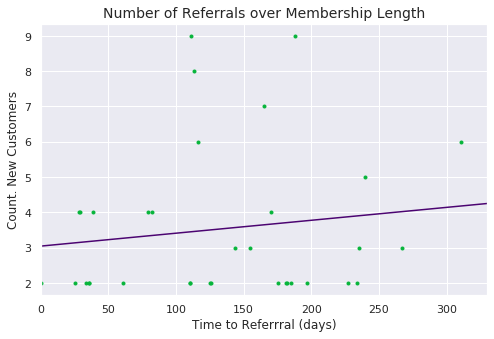

In [113]:
df_amazingReferrers = df_merge.groupby('referrer_customer_id').filter(lambda g: (g['referrer_customer_id'].size >1) & (g['referrer_customer_id'].size <=10))
# Remove anomaly: referrers who refer more than 1 but less or equal to 10 can be considered genuine. Any referrals more than 10 can be questionnable

sizeReferrer = df_amazingReferrers.groupby('referrer_customer_id').size()
sizeReferrer.name = 'num_of_referrals'

median_daydiff = df_amazingReferrers.groupby(['referrer_customer_id'])['day_diff'].median()
median_daydiff.name = 'median_daydiff'

len(sizeReferrer) == len(median_daydiff)

plt.figure(1, figsize = (8, 5))
df_referrerTime = pd.concat([sizeReferrer, median_daydiff], axis = 1)
df_referrerTime = df_referrerTime.dropna(subset = ['median_daydiff'])
x = df_referrerTime['median_daydiff']
y = df_referrerTime['num_of_referrals']

xp = np.linspace(0, 330, 1000)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.xlim([0, 330])
plt.plot(x, y, '.', c = cfg['color_palette']['green'])
plt.plot(xp, p(xp), '-', c = cfg['color_palette']['purple'])
plt.title('Number of Referrals over Membership Length', fontsize = cfg['plot']['title_fs'])
plt.xlabel('Time to Referrral (days)')
plt.ylabel('Count. New Customers')
plt.savefig(cfg['directory']['output']+ "/Scatter_BestFit_Time_CountNewCustomer.png")

In [114]:
sm.OLS(x, y).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         median_daydiff   R-squared (uncentered):                   0.602
Model:                            OLS   Adj. R-squared (uncentered):              0.590
Method:                 Least Squares   F-statistic:                              49.92
Date:                Mon, 28 Oct 2019   Prob (F-statistic):                    4.36e-08
Time:                        13:04:07   Log-Likelihood:                         -203.94
No. Observations:                  34   AIC:                                      409.9
Df Residuals:                      33   BIC:                                      411.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
num_of_referrals    29.2220      4.136      7.065      0.000      20.807      37.637
==============================================================================
Omnibus:                        6.301   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                2.020
Skew:                          -0.044   Prob(JB):                        0.364
Kurtosis:                       1.809   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

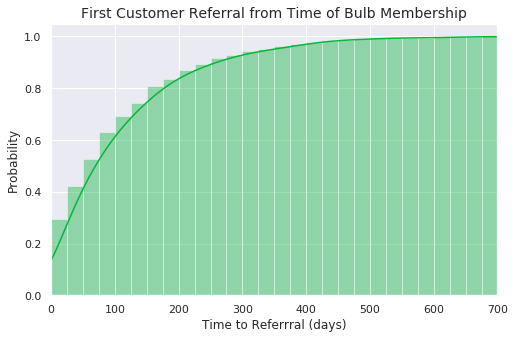

In [115]:
# The first referreral made since joining
plt.figure(1, figsize = (8, 5))
x = df_merge.sort_values('referral_date', ascending = True).\
drop_duplicates(subset = ['referrer_customer_id'], keep = 'first').loc[:, 'day_diff'].dropna()

bins = calculateNumBins(x, 25)
sns.distplot(x,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True), color = cfg['color_palette']['green'], bins = bins)
plt.xlim([0, 700])
plt.title("First Customer Referral from Time of Bulb Membership", fontsize = cfg['plot']['title_fs'])
plt.xlabel('Time to Referrral (days)')
plt.ylabel('Probability')
plt.savefig(cfg['directory']['output']+ "/CDF_CustomerReferral.png")

In [116]:
# This cumulative density function plot shows ~60% of the referrers make their first referrals 
# on the first 100 days (~3 months) of joining Bulb. 80% in the first half year.